# UK Road Safety: Supervised Learning Project
This notebook predicts accident severity (Slight, Serious, Fatal) using UK Road Safety Data (STATS19) from data.gov.uk.  
We load, merge, and preprocess data from Accidents, Casualties, and Vehicles datasets, then train multiple for multi-class classification.

Target = 'Collision_severity'
1 = Slight: Minor injuries, not life-threatening (e.g., bruises, sprains).
2 = Serious: More severe injuries, but not fatal (e.g., fractures, hospital admission).
3 = Fatal: At least one person died as a result of the accident.

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import requests
import zipfile
import io
import warnings
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')  # Ignore warnings to keep the output clean.
import lightgbm as lgb


## Load Data
Last 5 years (2020-2024) of Accidents, Casualties, and Vehicles data from CSV URLs.

In [25]:
# Download and load the Accidents dataset
accidents_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-last-5-years.csv"
accidents_df = pd.read_csv(io.StringIO(requests.get(accidents_url).text), low_memory=False)

# Download and load the Casualties dataset
casualties_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-casualty-last-5-years.csv"
casualties_df = pd.read_csv(io.StringIO(requests.get(casualties_url).text), low_memory=False)

# Download and load the Vehicles dataset
vehicles_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-vehicle-last-5-years.csv"
vehicles_df = pd.read_csv(io.StringIO(requests.get(vehicles_url).text), low_memory=False)

# Merge all datasets using the 'collision_index' column
df = accidents_df.merge(casualties_df, on='collision_index', how='left', suffixes=('', '_cas'))
df = df.merge(vehicles_df, on='collision_index', how='left', suffixes=('', '_veh'))

# Free up memory by deleting the original dataframes
del accidents_df, casualties_df, vehicles_df
import gc
gc.collect()

720

## Exploratory Data Analysis (EDA)
Explore the distribution of the target variable and key features to understand class balance and data characteristics.

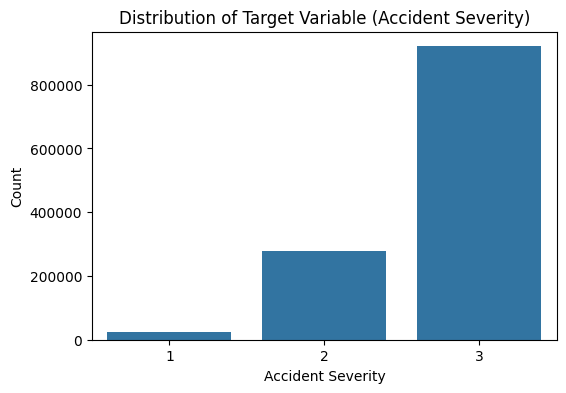

collision_severity
3    920089
2    277034
1     24164
Name: count, dtype: int64


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of accident severity in the dataset
plt.figure(figsize=(6,4))
sns.countplot(x='collision_severity', data=df)
plt.title('Distribution of Target Variable (Accident Severity)')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.show()

# Print the count of each severity class
print(df['collision_severity'].value_counts())

collision_severity,1,2,3
year,,,
2020,4231,44828,171376
2021,4668,53071,188575
2022,5129,59465,193606
2023,5151,59568,188180
2024,4985,60102,178352


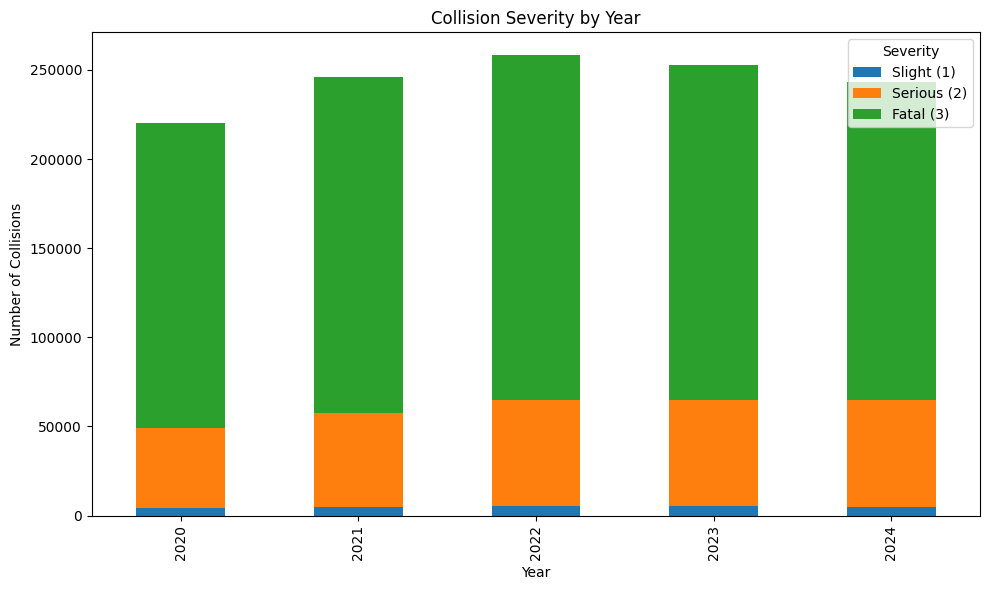

In [27]:
# Show a table and chart of accident severity counts for each year
if 'date' in df.columns:
    # Extract the year from the 'date' column (expects format like YYYY-MM-DD)
    df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
    severity_year_table = pd.crosstab(df['year'], df['collision_severity'])
    display(severity_year_table)
    severity_year_table.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title('Collision Severity by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Collisions')
    plt.legend(title='Severity', labels=['Slight (1)', 'Serious (2)', 'Fatal (3)'])
    plt.tight_layout()
    plt.show()
else:
    print("No 'date' column found in the dataset to extract year.")

## Verify Features and Target
Validate features and target, inspect missing values, data types, and target distribution.

In [28]:
# Verify all features and target in the entire dataset
target = 'collision_severity'

print(f"Total columns in dataset: {len(df.columns)}")
print(f"Total rows in dataset: {len(df)}")

print("\nMissing values across all columns:")
missing_info = df.isnull().sum()
print(missing_info[missing_info > 0]) if missing_info.sum() > 0 else print("No missing values found.")

print("\nData types of all columns:")
print(df.dtypes)

if target in df.columns:
    print("\nTarget distribution:")
    print(df[target].value_counts())
else:
    print(f"\nWarning: Target column '{target}' not found in dataset.")

Total columns in dataset: 98
Total rows in dataset: 1221287

Missing values across all columns:
location_easting_osgr              144
location_northing_osgr             144
longitude                          144
latitude                           144
local_authority_highway_current    217
dtype: int64

Data types of all columns:
collision_index             object
collision_year               int64
collision_ref_no            object
location_easting_osgr      float64
location_northing_osgr     float64
                            ...   
driver_imd_decile            int64
lsoa_of_driver              object
escooter_flag                int64
driver_distance_banding      int64
year                         int32
Length: 98, dtype: object

Target distribution:
collision_severity
3    920089
2    277034
1     24164
Name: count, dtype: int64


## Handle Outliers
Detect and cap outliers in numerical features using the IQR method to prevent model skewing.

In [29]:
# Drop unnecessary columns (identifiers, redundant info, or columns with too many missing values)
# Drop columns that are clearly not predictive or are unique identifiers
# Drop leaky features (anything containing 'severity' or 'adjusted' that isn't the target)

target = 'collision_severity'
cols_to_drop = [
    'accident_index', 'accident_reference', 'collision_index', 'collision_reference',
    'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude',
    'lsoa_of_accident_location', 'local_authority_highway', 'collision_ref_no',
    'collision_ref_no_cas', 'collision_ref_no_veh', 'lsoa_of_casualty', 'lsoa_of_driver'
]

# Identify leaky features and identifiers dynamically
leaky_or_id_cols = [
    col for col in df.columns 
    if (('severity' in col.lower() or 'adjusted' in col.lower() or 'ref' in col.lower() or 'no' in col.lower()) 
        and col != target)
]
cols_to_drop.extend(leaky_or_id_cols)

# Also drop columns with more than 50% missing values
threshold = 0.5
missing_info = df.isnull().mean()
high_missing_cols = missing_info[missing_info > threshold].index.tolist()
cols_to_drop.extend(high_missing_cols)

# Remove duplicates in the list and drop from df
cols_to_drop = list(set([c for c in cols_to_drop if c in df.columns]))
print(f"Dropping {len(cols_to_drop)} unnecessary/leaky/high-missing columns.")
df = df.drop(columns=cols_to_drop)

# Identify all numerical features in the remaining dataset for outlier detection
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude target and any remaining ID-like columns
features_to_exclude = [target] + [col for col in df.columns if 'id' in col.lower() or 'index' in col.lower()]
numerical_features = [col for col in numerical_features if col not in features_to_exclude]

print(f"\nNumerical features identified for outlier handling: {numerical_features}")

for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outlier values to the IQR bounds
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

print("\nOutlier handling (IQR capping) complete for all numerical features.")


Dropping 24 unnecessary/leaky/high-missing columns.

Numerical features identified for outlier handling: ['collision_year', 'police_force', 'number_of_vehicles', 'number_of_casualties', 'day_of_week', 'local_authority_district', 'first_road_class', 'first_road_number', 'road_type', 'speed_limit', 'junction_detail_historic', 'junction_detail', 'junction_control', 'second_road_class', 'second_road_number', 'pedestrian_crossing_human_control_historic', 'pedestrian_crossing_physical_facilities_historic', 'pedestrian_crossing', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards_historic', 'carriageway_hazards', 'urban_or_rural_area', 'trunk_road_flag', 'collision_injury_based', 'collision_year_cas', 'casualty_class', 'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty', 'pedestrian_location', 'pedestrian_movement', 'car_passenger', 'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker', 'casualty_type', 'ca

## Feature Selection

Create new features, binning of featurues and identifing top 15 most predictive features. Then information value for serious class.

In [30]:
# Feature Engineering and Selection using LightGBM as base
# 1. Feature Engineering
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek

if 'time' in df.columns:
    # Extract hour and minutes from time string (HH:MM)
    df['hour'] = df['time'].apply(lambda x: int(x.split(':')[0]) if isinstance(x, str) and ':' in x else np.nan)
    df['time_minutes'] = df['time'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if isinstance(x, str) and ':' in x else np.nan)

# Refined Binning
if 'age_of_casualty' in df.columns:
    df['age_bin'] = pd.cut(df['age_of_casualty'], bins=[0, 12, 19, 35, 50, 65, 100], 
                           labels=['child', 'teen', 'young_adult', 'adult', 'middle_aged', 'senior'])

if 'speed_limit' in df.columns:
    df['speed_bin'] = pd.cut(df['speed_limit'], bins=[0, 20, 30, 40, 50, 60, 70, 100], 
                             labels=['v_low', 'low', 'm_low', 'med', 'm_high', 'high', 'v_high'])

# 2. Prepare for Feature Selection
target = 'collision_severity'
# Drop non-predictive columns created during engineering or original ones
cols_to_exclude = [target, 'date', 'time']
features = [col for col in df.columns if col not in cols_to_exclude]

X_sel = df[features].copy()
y_sel = df[target].copy()

# Handle categorical features for LightGBM
cat_features = []
for col in X_sel.columns:
    if X_sel[col].dtype == 'object' or X_sel[col].dtype.name == 'category':
        X_sel[col] = X_sel[col].astype('category').cat.codes
        cat_features.append(col)

# 3. Feature Selection using LightGBM Importance (Fast)
print(f"Running feature selection on {len(features)} features using LightGBM...")
# Use a subset for speed if dataset is very large
if len(X_sel) > 200000:
    X_sample = X_sel.sample(200000, random_state=42)
    y_sample = y_sel.loc[X_sample.index]
else:
    X_sample = X_sel
    y_sample = y_sel

# Train a simple LightGBM model to get feature importance
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
lgb_model.fit(X_sample, y_sample)

# Get feature importances and select top 15
importances = pd.Series(lgb_model.feature_importances_, index=features).sort_values(ascending=False)
selected_features = importances.head(15).index.tolist()

print("\nTop 15 Selected Features:")
print(importances.head(15))

# Update global features list
features = selected_features


Running feature selection on 76 features using LightGBM...

Top 15 Selected Features:
time_minutes                                   758
age_of_casualty                                665
casualty_type                                  565
police_force                                   549
local_authority_ons_district                   507
number_of_casualties                           419
local_authority_highway_current                361
engine_capacity_cc                             334
first_road_number                              309
generic_make_model                             303
age_of_driver                                  296
speed_limit                                    259
first_point_of_impact                          224
month                                          210
did_police_officer_attend_scene_of_accident    206
dtype: int32


In [31]:
# Calculate Information Value (IV) for each feature wrt class 1 (Serious)
# We'll check IV for Serious (1) as it's often the hardest to distinguish.
def calculate_iv(feature, target, class_of_interest=1):
    df_temp = pd.DataFrame({'feature': feature, 'target': target})
    df_temp['target_bin'] = (df_temp['target'] == class_of_interest).astype(int)
    
    # For continuous features, we should bin them first, but here they are mostly categorical or binned
    grouped = df_temp.groupby('feature')['target_bin'].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    
    total_event = grouped['sum'].sum()
    total_non_event = grouped['non_event'].sum()
    
    # Avoid division by zero
    grouped = grouped[(grouped['sum'] > 0) & (grouped['non_event'] > 0)]
    
    grouped['pct_event'] = grouped['sum'] / total_event
    grouped['pct_non_event'] = grouped['non_event'] / total_non_event
    
    grouped['woe'] = np.log(grouped['pct_event'] / grouped['pct_non_event'])
    grouped['iv'] = (grouped['pct_event'] - grouped['pct_non_event']) * grouped['woe']
    
    iv_total = grouped['iv'].sum()
    return iv_total

print("Calculating Information Value (IV) for selected features...")
iv_scores = []
for feat in features:
    iv = calculate_iv(df[feat], df[target], class_of_interest=1)
    iv_scores.append(iv)

iv_df = pd.DataFrame({'feature': features, 'iv_score': iv_scores})
iv_df = iv_df.sort_values('iv_score', ascending=False)
print("\nInformation Value Scores (Predictive Power for 'Serious' class):")
print(iv_df)

# We keep all features selected before as they were already filtered for performance,
# IV helps us understand which ones are the strongest.
print(f"\nFinal features for modeling: {features}")

Calculating Information Value (IV) for selected features...

Information Value Scores (Predictive Power for 'Serious' class):
                                        feature  iv_score
14  did_police_officer_attend_scene_of_accident  0.748638
4                  local_authority_ons_district  0.670611
11                                  speed_limit  0.670411
8                             first_road_number  0.596639
6               local_authority_highway_current  0.562511
0                                  time_minutes  0.548201
5                          number_of_casualties  0.444038
3                                  police_force  0.376121
12                        first_point_of_impact  0.306364
9                            generic_make_model  0.285006
7                            engine_capacity_cc  0.250488
2                                 casualty_type  0.249746
1                               age_of_casualty  0.189274
10                                age_of_driver  0.159071
13  

## Preprocess Data
Drop rows with missing values in features/target, encode categorical features, and split into train/test sets.

In [32]:
# Class Balancing and Mapping
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

target = 'collision_severity'

# Ensure we only use selected features and drop NaNs
df_final = df[features + [target]].dropna()

X = df_final[features]
y = df_final[target]

# Mapping as requested: 0: Slight, 1: Serious, 2: Fatal
severity_map = {1: 0, 2: 1, 3: 2}
print(f"Mapping severity values: {severity_map}")
y = y.map(severity_map)

# Note: Based on original counts, Class 0 (Slight) is the minority and Class 2 (Fatal) is the majority.
orig_counts = Counter(y)
print("Original counts (0=Slight, 1=Serious, 2=Fatal):", orig_counts)

# Balance classes to 100,000 samples each
target_size = 100000

# Undersample majority classes
rus_strategy = {k: target_size for k, v in orig_counts.items() if v > target_size}
if rus_strategy:
    rus = RandomUnderSampler(random_state=42, sampling_strategy=rus_strategy)
    X_resampled, y_resampled = rus.fit_resample(X, y)
else:
    X_resampled, y_resampled = X, y

# Oversample minority classes
resampled_counts = Counter(y_resampled)
ros_strategy = {k: target_size for k, v in resampled_counts.items() if v < target_size}
if ros_strategy:
    ros = RandomOverSampler(random_state=42, sampling_strategy=ros_strategy)
    X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

print("Resampled counts:", Counter(y_resampled))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Mapping severity values: {1: 0, 2: 1, 3: 2}
Original counts (0=Slight, 1=Serious, 2=Fatal): Counter({2: 919935, 1: 276972, 0: 24163})
Resampled counts: Counter({0: 100000, 1: 100000, 2: 100000})

Training set size: 240000
Test set size: 60000


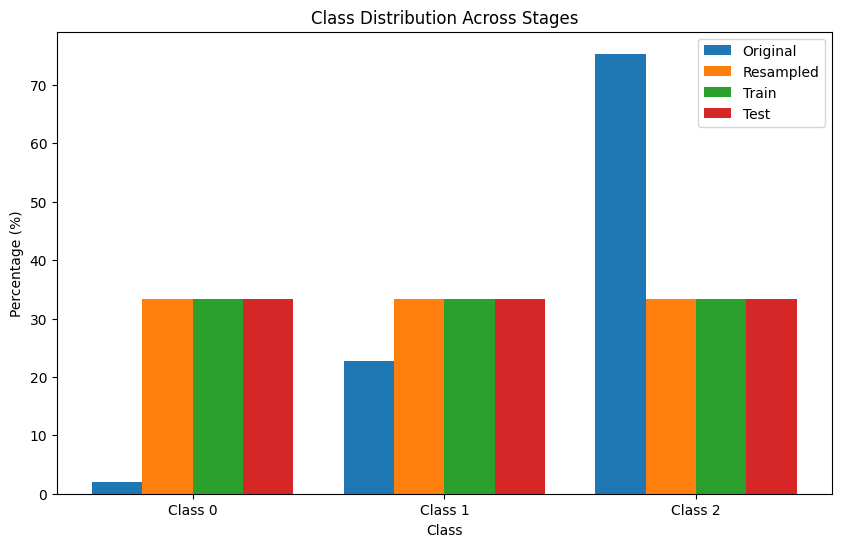

In [33]:
# Visualize class distributions
import matplotlib.pyplot as plt
from collections import Counter

orig_dist = Counter(y)
resampled_dist = Counter(y_resampled)
train_dist = Counter(y_train)
test_dist = Counter(y_test)

# Calculate totals
orig_total = sum(orig_dist.values())
resampled_total = sum(resampled_dist.values())
train_total = sum(train_dist.values())
test_total = sum(test_dist.values())

# Prepare percentage data
classes = sorted(set(orig_dist.keys()) | set(resampled_dist.keys()) | set(train_dist.keys()) | set(test_dist.keys()))
stages = ['Original', 'Resampled', 'Train', 'Test']
data_pct = {
    'Original': [(orig_dist.get(cls, 0) / orig_total * 100) if orig_total > 0 else 0 for cls in classes],
    'Resampled': [(resampled_dist.get(cls, 0) / resampled_total * 100) if resampled_total > 0 else 0 for cls in classes],
    'Train': [(train_dist.get(cls, 0) / train_total * 100) if train_total > 0 else 0 for cls in classes],
    'Test': [(test_dist.get(cls, 0) / test_total * 100) if test_total > 0 else 0 for cls in classes]
}

# Plot
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(classes))
width = 0.2
for i, stage in enumerate(stages):
    ax.bar(x + i*width, data_pct[stage], width, label=stage)
ax.set_xlabel('Class')
ax.set_ylabel('Percentage (%)')
ax.set_title('Class Distribution Across Stages')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([f'Class {cls}' for cls in classes])
ax.legend()
plt.show()

## Compare Models
Train and evaluate multiple models on the balanced dataset.

Training LightGBM...
LightGBM Accuracy: 0.7158
Training XGBoost...
XGBoost Accuracy: 0.6081
Training RandomForest...
RandomForest Accuracy: 0.5363


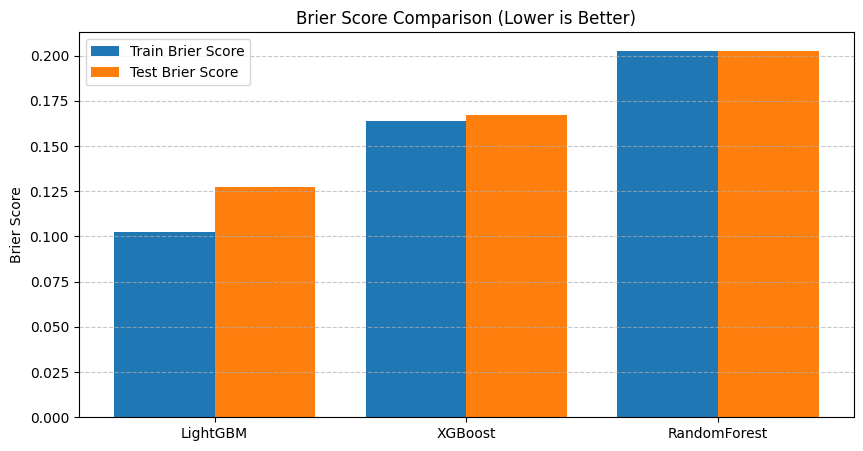


Overall Best Model: LightGBM with 0.7158 accuracy


In [34]:
# Model Comparison: LightGBM, XGBoost, RandomForest
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt
import numpy as np

# Identify categorical features for LightGBM
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Prepare data for LightGBM (needs 'category' type)
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
for col in categorical_features:
    X_train_lgb[col] = X_train_lgb[col].astype('category')
    X_test_lgb[col] = X_test_lgb[col].astype('category')

# For XGB and RF, we need to encode categories if they aren't already
X_train_enc = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
# Align columns
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

models = {
    'LightGBM': lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, num_leaves=63, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

results = {}
brier_train = []
brier_test = []
model_names = []

def multiclass_brier_score(y_true, y_prob, n_classes):
    score = 0
    for i in range(n_classes):
        y_true_bin = (y_true == i).astype(int)
        score += brier_score_loss(y_true_bin, y_prob[:, i])
    return score / n_classes

n_classes = len(np.unique(y_train))

for name, model in models.items():
    print(f"Training {name}...")
    if name == 'LightGBM':
        model.fit(X_train_lgb, y_train)
        prob_train = model.predict_proba(X_train_lgb)
        prob_test = model.predict_proba(X_test_lgb)
        acc = accuracy_score(y_test, model.predict(X_test_lgb))
    else:
        model.fit(X_train_enc, y_train)
        prob_train = model.predict_proba(X_train_enc)
        prob_test = model.predict_proba(X_test_enc)
        acc = accuracy_score(y_test, model.predict(X_test_enc))
    
    results[name] = acc
    brier_train.append(multiclass_brier_score(y_train, prob_train, n_classes))
    brier_test.append(multiclass_brier_score(y_test, prob_test, n_classes))
    model_names.append(name)
    print(f"{name} Accuracy: {acc:.4f}")

# Plot Brier Scores
plt.figure(figsize=(10, 5))
x = np.arange(len(model_names))
plt.bar(x - 0.2, brier_train, 0.4, label='Train Brier Score')
plt.bar(x + 0.2, brier_test, 0.4, label='Test Brier Score')
plt.xticks(x, model_names)
plt.title('Brier Score Comparison (Lower is Better)')
plt.ylabel('Brier Score')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Select best model
best_name = max(results, key=results.get)
best_model = models[best_name]
print(f"\nOverall Best Model: {best_name} with {results[best_name]:.4f} accuracy")


## Evaluate Model
Predict on test set and print classification report with precision, recall, and F1-score for each class.

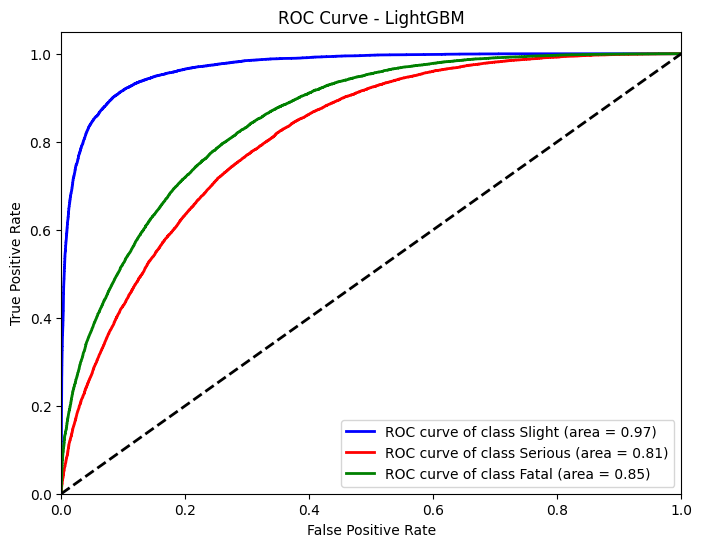

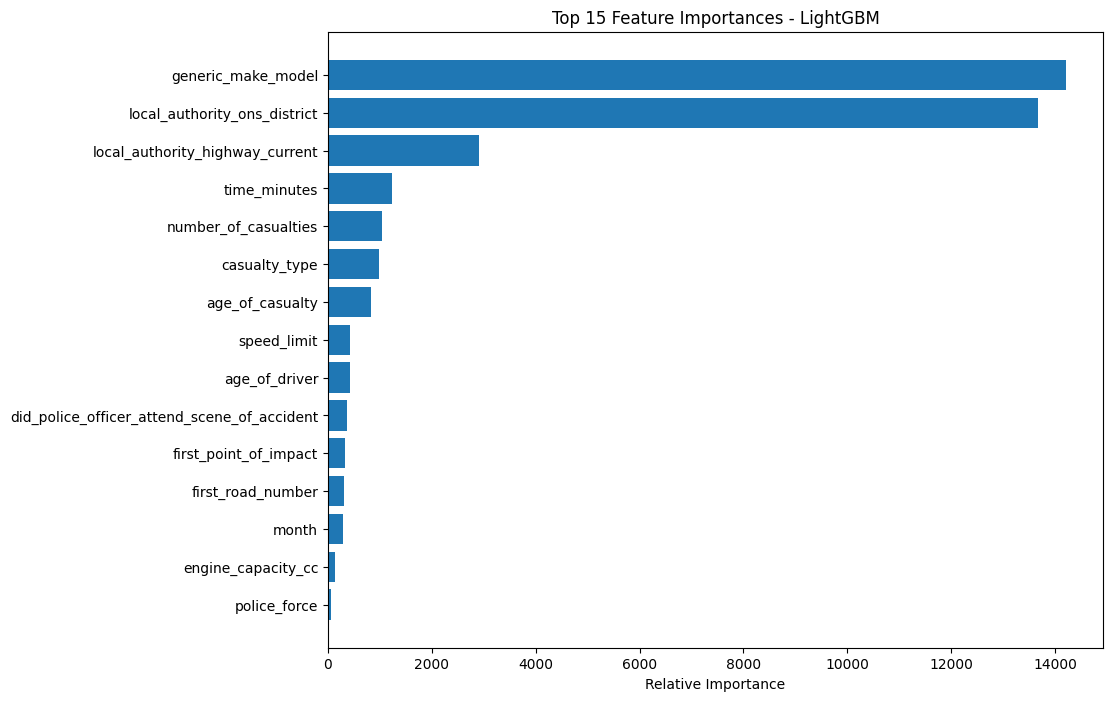

Classification Report for LightGBM:
              precision    recall  f1-score   support

      Slight       0.83      0.92      0.87     20000
     Serious       0.63      0.56      0.60     20000
       Fatal       0.66      0.67      0.67     20000

    accuracy                           0.72     60000
   macro avg       0.71      0.72      0.71     60000
weighted avg       0.71      0.72      0.71     60000



In [35]:
# Model Evaluation: ROC Curve & Feature Importance
from sklearn.metrics import roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ROC Curve for Best Model
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

if best_name == 'LightGBM':
    y_score = best_model.predict_proba(X_test_lgb)
else:
    y_score = best_model.predict_proba(X_test_enc)

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
labels = ['Slight', 'Serious', 'Fatal']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve of class {labels[i]} (area = {roc_auc:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_name}')
plt.legend(loc="lower right")
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 8))
if best_name == 'LightGBM':
    importances = best_model.feature_importances_
    feat_names = features
elif best_name == 'RandomForest':
    importances = best_model.feature_importances_
    feat_names = X_train_enc.columns
else: # XGBoost
    importances = best_model.feature_importances_
    feat_names = X_train_enc.columns

indices = np.argsort(importances)[-15:] # Top 15
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title(f'Top 15 Feature Importances - {best_name}')
plt.show()

# Classification Report
if best_name == 'LightGBM':
    y_pred = best_model.predict(X_test_lgb)
else:
    y_pred = best_model.predict(X_test_enc)

print(f"Classification Report for {best_name}:")
print(classification_report(y_test, y_pred, target_names=['Slight', 'Serious', 'Fatal']))


In [36]:
# Out-of-Time (OOT) Evaluation: 2025 Provisional Data
print("Loading 2025 Provisional OOT Data...")

# URLs for 2025 provisional data
oot_accidents_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-provisional-2025.csv"
oot_casualties_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-casualty-provisional-2025.csv"
oot_vehicles_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-vehicle-provisional-2025.csv"

try:
    oot_accidents = pd.read_csv(io.StringIO(requests.get(oot_accidents_url).text), low_memory=False)
    oot_casualties = pd.read_csv(io.StringIO(requests.get(oot_casualties_url).text), low_memory=False)
    oot_vehicles = pd.read_csv(io.StringIO(requests.get(oot_vehicles_url).text), low_memory=False)

    # Merge like the training data
    df_oot = oot_accidents.merge(oot_casualties, on='collision_index', how='left', suffixes=('', '_cas'))
    df_oot = df_oot.merge(oot_vehicles, on='collision_index', how='left', suffixes=('', '_veh'))

    print(f"OOT Dataset Loaded: {len(df_oot)} rows")

    # Preprocess OOT data (Feature Engineering)
    if 'date' in df_oot.columns:
        df_oot['date'] = pd.to_datetime(df_oot['date'], errors='coerce')
        df_oot['month'] = df_oot['date'].dt.month
        df_oot['day_of_week'] = df_oot['date'].dt.dayofweek

    if 'time' in df_oot.columns:
        df_oot['hour'] = df_oot['time'].apply(lambda x: int(x.split(':')[0]) if isinstance(x, str) and ':' in x else np.nan)
        df_oot['time_minutes'] = df_oot['time'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if isinstance(x, str) and ':' in x else np.nan)

    if 'age_of_casualty' in df_oot.columns:
        df_oot['age_bin'] = pd.cut(df_oot['age_of_casualty'], bins=[0, 12, 19, 35, 50, 65, 100], 
                                   labels=['child', 'teen', 'young_adult', 'adult', 'middle_aged', 'senior'])

    if 'speed_limit' in df_oot.columns:
        df_oot['speed_bin'] = pd.cut(df_oot['speed_limit'], bins=[0, 20, 30, 40, 50, 60, 70, 100], 
                                     labels=['v_low', 'low', 'm_low', 'med', 'm_high', 'high', 'v_high'])

    # Map target
    df_oot = df_oot.dropna(subset=[target])
    df_oot[target] = df_oot[target].map(severity_map)
    df_oot = df_oot.dropna(subset=[target]) # Drop if mapping failed

    # Prepare X_oot
    X_oot = df_oot[features].copy()
    y_oot = df_oot[target]

    # Handle categorical features for LightGBM
    if best_name == 'LightGBM':
        # Use the same categorical features list as training
        for col in categorical_features:
            if col in X_oot.columns:
                X_oot[col] = X_oot[col].astype('category')
        
        # Ensure column order matches training
        X_oot = X_oot[features]
        y_pred_oot = best_model.predict(X_oot)
    else:
        # For XGB/RF, use the same encoding as training
        X_oot_enc = pd.get_dummies(X_oot, columns=categorical_features, drop_first=True)
        X_oot_enc, _ = X_oot_enc.align(X_train_enc, join='right', axis=1, fill_value=0)
        y_pred_oot = best_model.predict(X_oot_enc)

    print(f"\nOOT Evaluation (2025 Provisional) for {best_name}:")
    print(f"Accuracy: {accuracy_score(y_oot, y_pred_oot):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_oot, y_pred_oot, target_names=['Slight', 'Serious', 'Fatal']))

except Exception as e:
    print(f"Error loading or processing OOT data: {e}")


Loading 2025 Provisional OOT Data...
OOT Dataset Loaded: 114852 rows

OOT Evaluation (2025 Provisional) for LightGBM:
Accuracy: 0.6062

Classification Report:
              precision    recall  f1-score   support

      Slight       0.07      0.30      0.12      2216
     Serious       0.37      0.53      0.44     29772
       Fatal       0.84      0.64      0.73     82864

    accuracy                           0.61    114852
   macro avg       0.43      0.49      0.43    114852
weighted avg       0.70      0.61      0.64    114852



## Make Predictions
Check the prediction.

In [37]:
# Make Predictions
# Build a sample input that matches the model's expected features
print("Model expects features:", features)

# Create a sample input with default values
sample_data = {f: 0 for f in features}

# Update with some realistic values for a test prediction
# Note: These should be encoded values if the model was trained on encoded data.
# Since we used LightGBM with categorical features, we'll use common values.

if 'police_force' in sample_data: sample_data['police_force'] = 1
if 'number_of_casualties' in sample_data: sample_data['number_of_casualties'] = 1
if 'speed_limit' in sample_data: sample_data['speed_limit'] = 30
if 'age_of_casualty' in sample_data: sample_data['age_of_casualty'] = 25
if 'engine_capacity_cc' in sample_data: sample_data['engine_capacity_cc'] = 1600
if 'month' in sample_data: sample_data['month'] = 6
if 'time_minutes' in sample_data: sample_data['time_minutes'] = 600 # 10:00 AM

sample_input = pd.DataFrame([sample_data])

# Ensure column order matches exactly what the model saw during training
sample_input = sample_input[features]

# Handle categorical features for LightGBM
if best_name == 'LightGBM':
    for col in categorical_features:
        if col in sample_input.columns:
            sample_input[col] = sample_input[col].astype('category')
    prediction = best_model.predict(sample_input)
else:
    # For XGB/RF, use the same encoding as training
    sample_input_enc = pd.get_dummies(sample_input, columns=categorical_features, drop_first=True)
    sample_input_enc, _ = sample_input_enc.align(X_train_enc, join='right', axis=1, fill_value=0)
    prediction = best_model.predict(sample_input_enc)

pred_val = prediction[0]

# Convert the predicted value to a text label (0=Slight, 1=Serious, 2=Fatal)
severity_map_text = {0: 'Slight', 1: 'Serious', 2: 'Fatal'}
pred_label = severity_map_text.get(pred_val, 'Unknown')

print(f'\nPredicted Severity for Sample Input: {pred_label}')


Model expects features: ['time_minutes', 'age_of_casualty', 'casualty_type', 'police_force', 'local_authority_ons_district', 'number_of_casualties', 'local_authority_highway_current', 'engine_capacity_cc', 'first_road_number', 'generic_make_model', 'age_of_driver', 'speed_limit', 'first_point_of_impact', 'month', 'did_police_officer_attend_scene_of_accident']

Predicted Severity for Sample Input: Serious
